# DFT atom

In [1]:
using Pkg;
Pkg.activate("../../SchrodingerEquationSolver");
include("../src/SchrodingerEquationSolver.jl");
import .SchrodingerEquationSolver as ses
import .ses.Grids as Grids
import .ses.Potentials as Potentials
import .ses.MathUtils as MathUtils
import .ses.Hydrogen as Hydrogen
import .ses.InitialConditions as InitialConditions
import .ses.OneDSchrodingerEquationSolver as odses
import .ses.OneDPoissonEquationSolver as odpes
import .ses.EigenvalueFinders as EigenvalueFinders
import .ses.AtomBasisSet as AtomBasisSet
import .ses.Density as Density
import .ses.ExchangeCorrelation as ExchangeCorrelation
using Plots

  Activating project at `~/Desktop/physics_coding_projects/julia/SchrodingerEquationSolver`


In [2]:
#Define parameters and produce an exponential grid.
r_max::Float64=25.0;#Max radius of space grid.
Z::Int64=37;#Atomic number, also used as the charge of coulomb potential.

## Exponential grid

In [3]:


grid_stru= Grids.init_exponential_grid_structure(r_max, Z);
grid= grid_stru.grid;
grid_i= grid_stru.grid_i;
a=grid_stru.a;
b=grid_stru.b;
c_i= (a*b).*(exp.(b.*grid_i));
grid_sqrt= grid.^2.0; 
N= size(grid)[1]; #Number of points in the grid.
print("grid size ", N)

grid size 8324

In [4]:
#Initialization of potentials and energies

#Initializing coulomb potential due to nuclei charge.
V_colu::Vector{Float64}= Potentials.coulomb_potential(Z, grid);
#Initializing Hartree potential due to electron density. 
V_hartree::Vector{Float64}=zeros(Float64, N);
#Initializing exchange potential.
V_x::Vector{Float64}=zeros(Float64, N);
#Initializing correlation potential.
V_c::Vector{Float64}=zeros(Float64, N);
#Initializing energy exchange potential.
E_xp::Vector{Float64}=zeros(Float64, N);
#Initializing energy correlation potential.
E_cp::Vector{Float64}=zeros(Float64, N);
#Initializing exchange + correlation potential.
V_xcp::Vector{Float64}=zeros(Float64, N);
#Initializing the density.
density_in::Vector{Float64}= zeros(Float64, N);
#Initializing total energy
E_total::Float64=1.0;
#Initializing total energy step before
E_total_before::Float64=2.0;
#Initializing energy from energy eigenvalues
E_eigen::Float64=0.0;
#Initializing exchange correlation potential value after integral
V_xc::Float64= 0.0;
#Initializing Hartree energy
E_hartree::Float64= 0.0;
#Initializing exchange energy
E_x::Float64= 0.0;
#Initializing correlation enrgy
E_c::Float64= 0.0;
#Initializing basis set data structure
basis= AtomBasisSet.init_atom_basis_set(Z, grid);

In [5]:
for i_orbi in basis.orbitals
    println(i_orbi.name)
    println(i_orbi.occu)
end

1s
2.0
2s
2.0
2p
6.0
3s
2.0
3p
6.0
4s
2.0
3d
10.0
4p
6.0
4d
1.0


In [6]:
#dev start

In [6]:
#Energy minimization loop 

E_eigen=0.0;
#Loop over every orbital to solve independent particle Schrodinger equation.
for i_orbi in basis.orbitals
    println(i_orbi.name)
    #angular potential for l orbital
    V_angu= Potentials.angular_potential(i_orbi.l, grid);
    #Assemble effective potential.
    V_effe= V_colu .+ V_angu .+ V_hartree .+ V_x .+ V_c;
    V_effe_max= maximum(V_effe)
    V_effe_min= minimum(V_effe)
    println("V_effe_max ", V_effe_max)
    println("V_effe_min ", V_effe_min)
    #Energy grid to search for new eigenvalue, search around the previous eigenvalue.
    #assuming i_orbi.E < 0
    E_guess_max= i_orbi.E - 0.10*i_orbi.E;
    E_guess_min= i_orbi.E + 0.01*i_orbi.E;
    println("E_guess_max initial", E_guess_max)
    println("E_guess_min initial", E_guess_min)
    while E_guess_max > V_effe_max
        if E_guess_max> 0
            E_guess_max= E_guess_max - 0.1*E_guess_max;
        else
            E_guess_max= E_guess_max + 0.1*E_guess_max;
        end
    end

    while E_guess_min < V_effe_min
        if E_guess_min < 0.0
            E_guess_min = E_guess_min - 0.1*E_guess_min;
        else
            E_guess_min = E_guess_min + 0.1*E_guess_min;
        end
    end
    println("E_guess_max final", E_guess_max)
    println("E_guess_min final", E_guess_min)
    #Search for a solution to the independent particle Schrodinger equation for the first energy interval, 
    #there should be only one interval. Any other interval would be of a higher energy.
    #u_temp, ei_temp= EigenvalueFinders.illinois_eigenvalue_finder(E_intervals[1], V_effe, grid,InitialConditions.atom);
    u_temp, ei_temp= EigenvalueFinders.illinois_eigenvalue_finder_v((E_guess_min, E_guess_max), V_effe, 
    grid_stru,InitialConditions.atom_v, l=i_orbi.l);
    #Update eigenvalue and eigenfunction in the basis set data structure.
    i_orbi.E=ei_temp;
    i_orbi.u=u_temp;
    E_eigen+= i_orbi.occu*ei_temp;
    println(i_orbi.E)
    println("--------------------------------")

end
#Update E_total_before from the E_total from the previous step.
E_total_before= float(E_total);
#Calculate density with new basis set.
density_out= Density.calculate_density(basis);
#Smooth the density with linear mixing (combination) of the previous and current densities.
density_in= Density.linear_mixing(density_in, density_out, alpha=0.10);
#Solve Poisson equation to find the new Hartree potential.
V_hartree= odpes.solver_v_return_V_hartree(Z, density_in, grid_stru);
#Calculate new exchange and correlation potentials.
V_x, E_xp, V_c, E_cp= ExchangeCorrelation.potentials(density_in);
#Add exchange and correlation potentials.
V_xcp= V_x .+ V_c;
#Integrals to calculate energy components.
V_xc= (4.0*pi)*MathUtils.integral((V_xcp.*density_in.*grid_sqrt.*c_i), grid_i);
E_hartree= 0.5*(4.0*pi)*(MathUtils.integral((V_hartree.*density_in.*grid_sqrt.*c_i), grid_i));
E_x= (4.0*pi)*MathUtils.integral((E_xp.*density_in.*grid_sqrt.*c_i), grid_i);
E_c= (4.0*pi)*MathUtils.integral((E_cp.*density_in.*grid_sqrt.*c_i), grid_i);
#C_in= (4.0*pi)*MathUtils.integral((density_in.*grid_sqrt), grid)
#C_out= (4.0*pi)*MathUtils.integral((density_out.*grid_sqrt), grid)
#Calculate total energy.
E_total= E_eigen - E_hartree + E_x + E_c - V_xc;

#println("*****************************************")

println("E_hartree ", E_hartree)
println("E_x + E_c ", (E_x + E_c))
println("E_total ", E_total)
#for i_orbi in basis.orbitals
#    println(i_orbi.name)
#    println(i_orbi.E)
#end

1s
V_effe_max -1.4784230897162212
V_effe_min -1.3675110383082043e11
E_guess_max initial-616.05
E_guess_min initial-691.345
E_guess_max final-616.05
E_guess_min final-691.345
-684.50000000003
--------------------------------
2s
V_effe_max -1.4784230897162212
V_effe_min -1.3675110383082043e11
E_guess_max initial-154.0125
E_guess_min initial-172.83625
E_guess_max final-154.0125
E_guess_min final-172.83625
-171.12500000000594
--------------------------------
2p
V_effe_max 1.366023682376594e19
V_effe_min -342.2499927473771
E_guess_max initial-154.0125
E_guess_min initial-172.83625
E_guess_max final-154.0125
E_guess_min final-172.83625
-171.12499999999693
--------------------------------
3s
V_effe_max -1.4784230897162212
V_effe_min -1.3675110383082043e11
E_guess_max initial-68.45
E_guess_min initial-76.81611111111111
E_guess_max final-68.45
E_guess_min final-76.81611111111111
-76.055555555554
--------------------------------
3p
V_effe_max 1.366023682376594e19
V_effe_min -342.2499927473771
E_

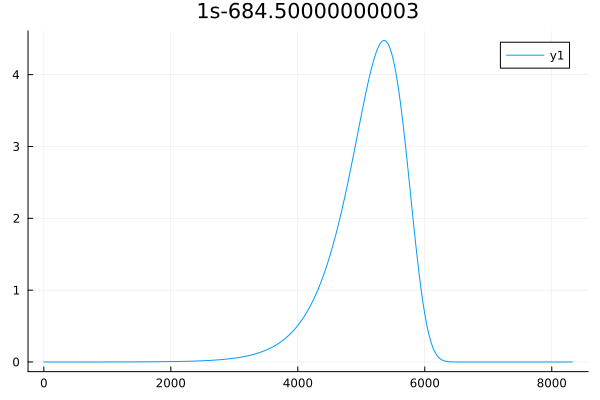

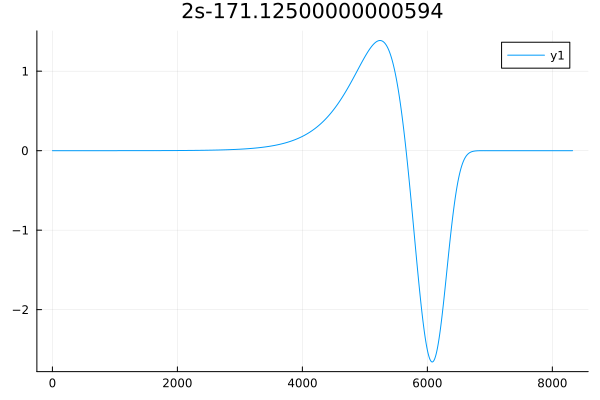

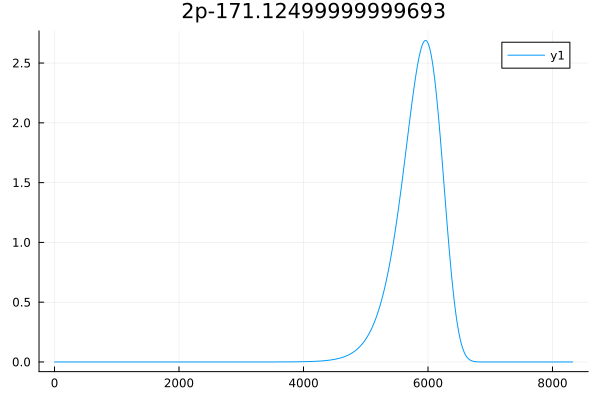

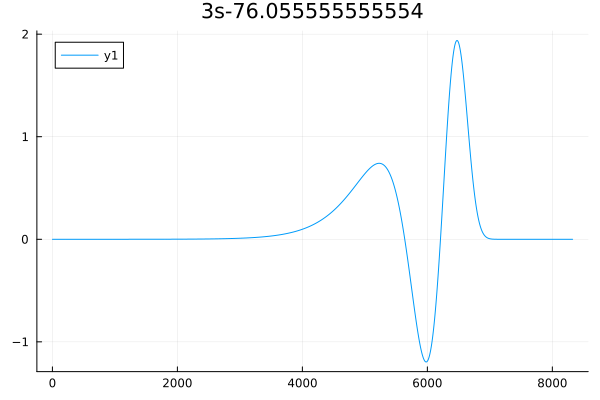

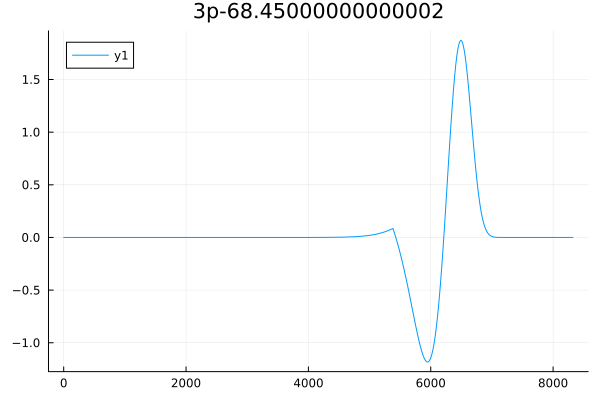

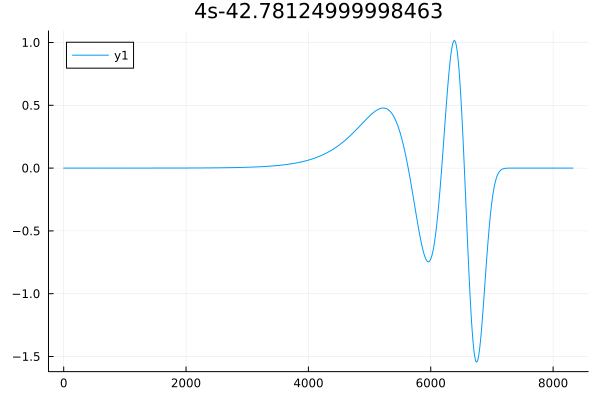

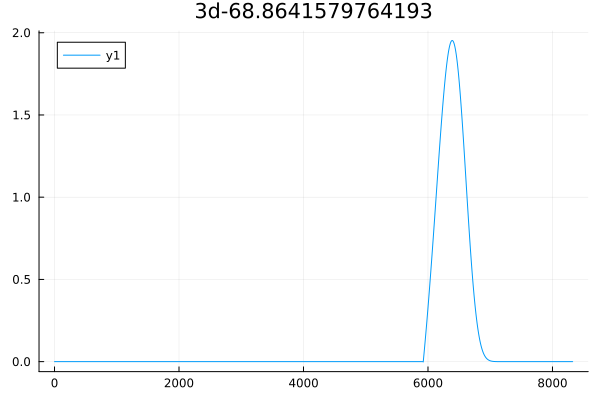

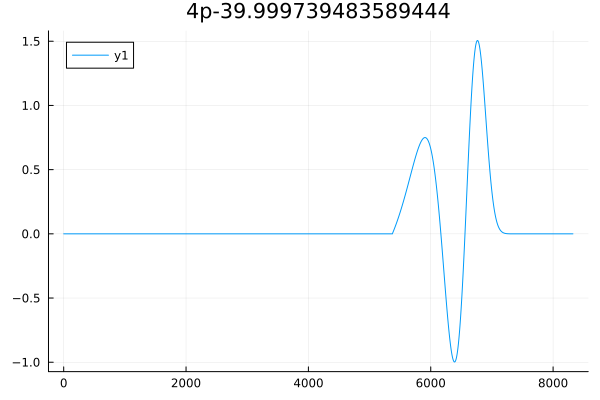

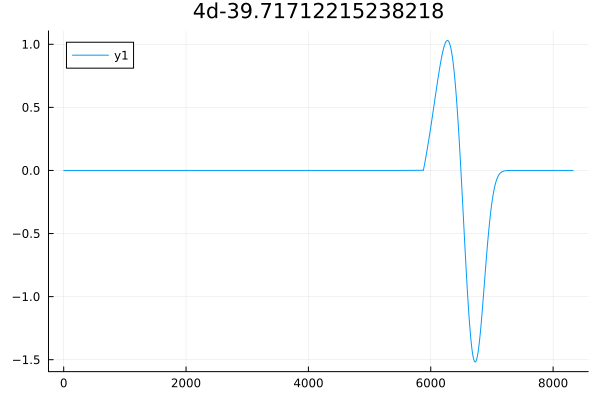

In [7]:
for i_orbi in basis.orbitals
    #println(i_orbi.name)
    #println(i_orbi.E)
    Plots.display(plot(grid_i, i_orbi.u, title= string(i_orbi.name,i_orbi.E)))
end

In [53]:

#Calculate new exchange and correlation potentials.
V_x, E_xp, V_c, E_cp= ExchangeCorrelation.potentials(density_in);
#Add exchange and correlation potentials.
V_xcp= V_x .+ V_c;
#Integrals to calculate energy components.
V_xc= (4.0*pi)*MathUtils.integral((V_xcp.*density_in.*grid_sqrt.*c_i), grid_i);
E_hartree= 0.5*(4.0*pi)*(MathUtils.integral((V_hartree.*density_in.*grid_sqrt.*c_i), grid_i));
E_x= (4.0*pi)*MathUtils.integral((E_xp.*density_in.*grid_sqrt.*c_i), grid_i);
E_c= (4.0*pi)*MathUtils.integral((E_cp.*density_in.*grid_sqrt.*c_i), grid_i);
#C_in= (4.0*pi)*MathUtils.integral((density_in.*grid_sqrt), grid)
#C_out= (4.0*pi)*MathUtils.integral((density_out.*grid_sqrt), grid)
#Calculate total energy.
E_total= E_eigen - E_hartree + E_x + E_c - V_xc;

#println("*****************************************")

println("E_hartree ", E_hartree)
println("E_x + E_c ", (E_x + E_c))
println("E_total ", E_total)
#for i_orbi in basis.orbitals
#    println(i_orbi.name)
#    println(i_orbi.E)
#end

In [7]:
#dev end

In [6]:
#Energy minimization loop 
while abs(E_total - E_total_before) > 10.0e-8
    E_eigen=0.0;
    #Loop over every orbital to solve independent particle Schrodinger equation.
    for i_orbi in basis.orbitals
        #println(i_orbi.name)
        #angular potential for l orbital
        V_angu= Potentials.angular_potential(i_orbi.l, grid);
        #Assemble effective potential.
        V_effe= V_colu .+ V_angu .+ V_hartree .+ V_x .+ V_c;
        V_effe_max= maximum(V_effe)
        V_effe_min= minimum(V_effe)
        #Energy grid to search for new eigenvalue, search around the previous eigenvalue.
        #assuming i_orbi.E < 0
        E_guess_max= i_orbi.E - 0.10*i_orbi.E;
        E_guess_min= i_orbi.E + 0.01*i_orbi.E;
        while E_guess_max > V_effe_max
            if E_guess_max> 0
                E_guess_max= E_guess_max - 0.1*E_guess_max;
            else
                E_guess_max= E_guess_max + 0.1*E_guess_max;
            end
        end

        while E_guess_min < V_effe_min
            if E_guess_min < 0.0
                E_guess_min = E_guess_min - 0.1*E_guess_min;
            else
                E_guess_min = E_guess_min + 0.1*E_guess_min;
            end
        end

        #Search for a solution to the independent particle Schrodinger equation for the first energy interval, 
        #there should be only one interval. Any other interval would be of a higher energy.
        #u_temp, ei_temp= EigenvalueFinders.illinois_eigenvalue_finder(E_intervals[1], V_effe, grid,InitialConditions.atom);
        u_temp, ei_temp= EigenvalueFinders.illinois_eigenvalue_finder_v((E_guess_min, E_guess_max), V_effe, 
        grid_stru,InitialConditions.atom_v, l=i_orbi.l);
        #Update eigenvalue and eigenfunction in the basis set data structure.
        i_orbi.E=ei_temp;
        i_orbi.u=u_temp;
        E_eigen+= i_orbi.occu*ei_temp;
        #println(i_orbi.E)
        #println("--------------------------------")

    end
    #Update E_total_before from the E_total from the previous step.
    E_total_before= float(E_total);
    #Calculate density with new basis set.
    density_out= Density.calculate_density(basis);
    #Smooth the density with linear mixing (combination) of the previous and current densities.
    density_in= Density.linear_mixing(density_in, density_out, alpha=0.10);
    #Solve Poisson equation to find the new Hartree potential.
    V_hartree= odpes.solver_v_return_V_hartree(Z, density_in, grid_stru);
    #Calculate new exchange and correlation potentials.
    V_x, E_xp, V_c, E_cp= ExchangeCorrelation.potentials(density_in);
    #Add exchange and correlation potentials.
    V_xcp= V_x .+ V_c;
    #Integrals to calculate energy components.
    V_xc= (4.0*pi)*MathUtils.integral((V_xcp.*density_in.*grid_sqrt.*c_i), grid_i);
    E_hartree= 0.5*(4.0*pi)*(MathUtils.integral((V_hartree.*density_in.*grid_sqrt.*c_i), grid_i));
    E_x= (4.0*pi)*MathUtils.integral((E_xp.*density_in.*grid_sqrt.*c_i), grid_i);
    E_c= (4.0*pi)*MathUtils.integral((E_cp.*density_in.*grid_sqrt.*c_i), grid_i);
    #C_in= (4.0*pi)*MathUtils.integral((density_in.*grid_sqrt), grid)
    #C_out= (4.0*pi)*MathUtils.integral((density_out.*grid_sqrt), grid)
    #Calculate total energy.
    E_total= E_eigen - E_hartree + E_x + E_c - V_xc;

    #println("*****************************************")
end
println("E_hartree ", E_hartree)
println("E_x + E_c ", (E_x + E_c))
println("E_total ", E_total)
for i_orbi in basis.orbitals
    println(i_orbi.name)
    println(i_orbi.E)
end

DomainError: DomainError with the effective potential has no turning points 
        for the proposed energy eigenvalue, this means v_effe - E has no zeroes:


In [7]:
for i_orbi in basis.orbitals
    println(i_orbi.name)
    println(i_orbi.occu)
end

1s
2.0
2s
2.0
2p
6.0
3s
2.0
3p
6.0
4s
2.0
3d
10.0
